# Tree species classification project -- Data Science of Earth Oberservation
Group members:


Input file: .npy

In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import torch
# Folium setup.
import folium

# Step 1. Input the npy data

In [2]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/data0116/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 74.88it/s]

Now all merge samples are saved!


# Step 2. Data preparation

In [3]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(2760, 1, 2)
(690, 1, 2)


In [4]:
kernel=9
bands=40
output_size = 10 
number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  kernel,kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [5]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]
X_val= np.zeros((number_samples,   kernel,kernel,bands), dtype=float)

for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [6]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples,  kernel*kernel*bands))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (2760, 3240)


In [7]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, kernel*kernel*bands))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (690, 3240)


# Step 3. Random forest classification

Random Forest: Random Forest is a supervised learning algorithm, it can be used to classify tree species using Sentinel-2 imagery.

In [8]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred_rf = rf_classifier.predict(X_val_rf)

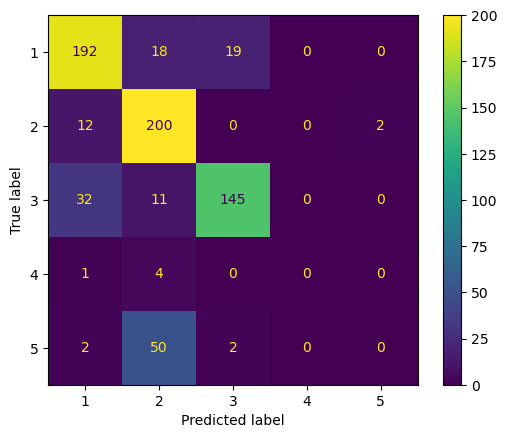

Accuracy Random Forest Classifier:  0.7782608695652173


In [10]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

# Step 4. Artificial Nueral Network (ANN) classification

In [11]:
number_samples = X_train.shape[0]
X_train_nn= np.zeros((number_samples,  kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_train_nn[i,:] = np.reshape(X_train[i,:], (  kernel*kernel,bands))
    X_train_nn[i,:]= np.array(pd.DataFrame(X_train_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_train_nn.shape)

Post-processed S2_train data shape:  (2760, 81, 40)


In [12]:
number_samples = X_val.shape[0]
X_val_nn= np.zeros((number_samples,   kernel*kernel,bands), dtype=float)
for i in range(0,number_samples-1):
    X_val_nn[i,:] = np.reshape(X_val[i,:], (  kernel*kernel,bands))
    X_val_nn[i,:]= np.array(pd.DataFrame(X_val_nn[i,:]).fillna(0))
print("Post-processed S2_train data shape: ", X_val_nn.shape)

Post-processed S2_train data shape:  (690, 81, 40)


In [30]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(kernel*kernel,bands)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(output_size, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

In [32]:
history = simple_model.fit(X_train_nn, Y_train, epochs=200,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=50)],  verbose=0,validation_data=(X_val_nn, Y_val))

Epoch 1/200


2023-01-18 02:07:15.629009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:07:16.998709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 2s 24ms/sample - loss: 1.0278 - accuracy: 0.5826 - val_loss: 0.9182 - val_accuracy: 0.6203
Epoch 51/200
87/87 [==============================] - 1s 9ms/sample - loss: 0.4955 - accuracy: 0.8101 - val_loss: 0.6519 - val_accuracy: 0.7667
Epoch 101/200
87/87 [==============================] - 1s 9ms/sample - loss: 0.4384 - accuracy: 0.8351 - val_loss: 0.5767 - val_accuracy: 0.7884
Epoch 151/200
87/87 [==============================] - 1s 7ms/sample - loss: 0.3666 - accuracy: 0.8525 - val_loss: 0.6927 - val_accuracy: 0.7696


In [33]:
y_pred_dl_p = simple_model.predict(X_val_nn)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

22/22 [==============================] - 0s 4ms/step
Prediction example:  [4.3456820e-09 2.7275546e-03 8.9048988e-01 3.2278013e-03 6.2994370e-03
 9.7255349e-02 3.0839598e-09 2.7312179e-09 2.9057092e-09 1.0573321e-08]  Class:  2


2023-01-18 02:10:38.165161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


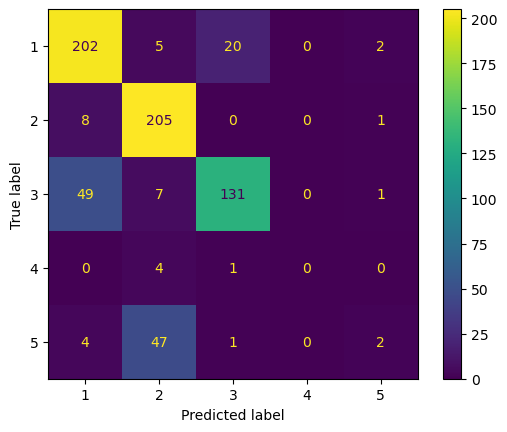

Accuracy Simple Deep Learning model:  0.782608695652174


In [34]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

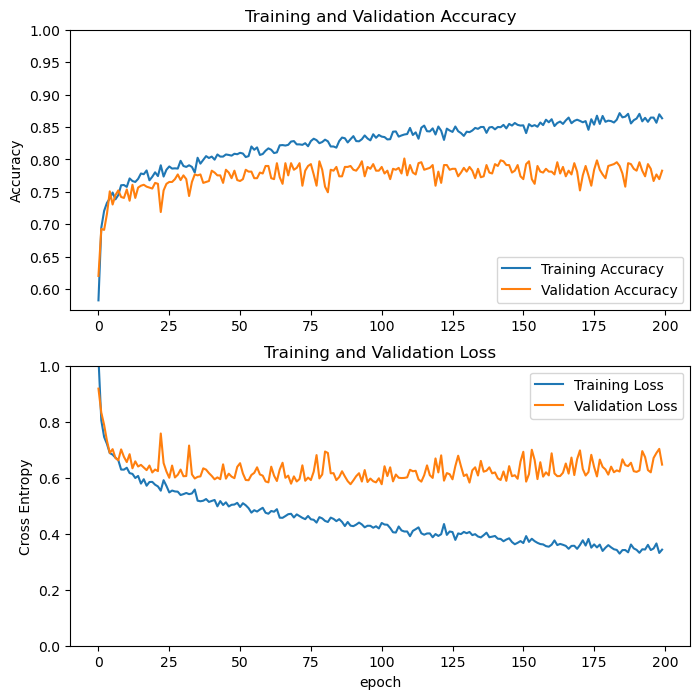

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
fine_tune_epochs = 200
initial_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = simple_model.fit(X_train_nn,Y_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=(X_val_nn,Y_val))

Epoch 200/210
87/87 [==============================] - 1s 9ms/step - loss: 0.3368 - accuracy: 0.8688 - val_loss: 0.6269 - val_accuracy: 0.7899
Epoch 201/210
87/87 [==============================] - 1s 8ms/step - loss: 0.3419 - accuracy: 0.8594 - val_loss: 0.7108 - val_accuracy: 0.7797
Epoch 202/210
87/87 [==============================] - 1s 8ms/step - loss: 0.3558 - accuracy: 0.8598 - val_loss: 0.6720 - val_accuracy: 0.7696
Epoch 203/210
87/87 [==============================] - 1s 7ms/step - loss: 0.3479 - accuracy: 0.8652 - val_loss: 0.6151 - val_accuracy: 0.7826
Epoch 204/210
87/87 [==============================] - 1s 8ms/step - loss: 0.3218 - accuracy: 0.8725 - val_loss: 0.6307 - val_accuracy: 0.7797
Epoch 205/210
87/87 [==============================] - 1s 8ms/step - loss: 0.3284 - accuracy: 0.8703 - val_loss: 0.6653 - val_accuracy: 0.7783
Epoch 206/210
87/87 [==============================] - 1s 8ms/step - loss: 0.3319 - accuracy: 0.8699 - val_loss: 0.6609 - val_accuracy: 0.7797

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

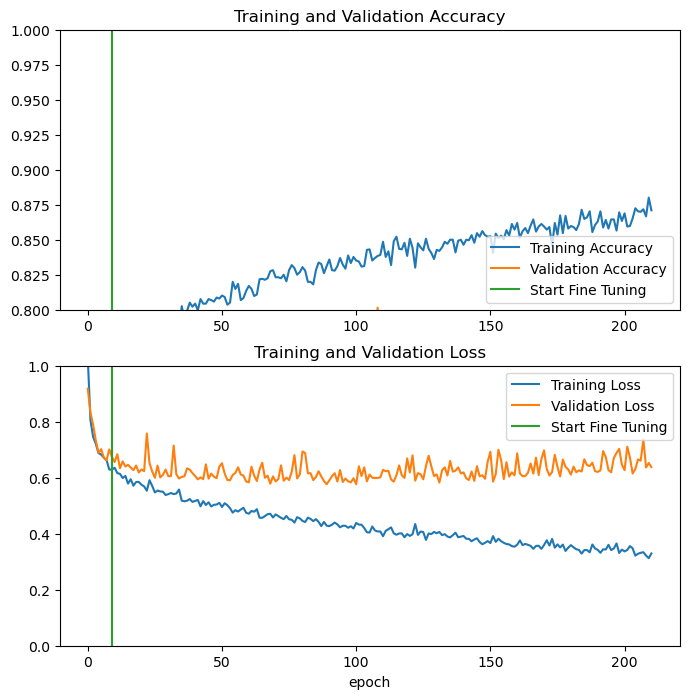

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
loss, accuracy = simple_model.evaluate(X_val_nn,Y_val)
print('Test accuracy :', accuracy)

22/22 [==============================] - 0s 6ms/step - loss: 0.6381 - accuracy: 0.7870
Test accuracy : 0.7869565486907959


# Step 5. Convolutional Neural Networks (CNNs) classification

Convolutional Neural Networks (CNNs): These are commonly used for image classification tasks and have been shown to be effective for tree species classification using Sentinel-2 imagery.

In [40]:
CNNs_model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu",input_shape=(kernel*kernel,bands,1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16)
]
)

In [41]:

CNNs_model.summary() 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [42]:

CNNs_model.add(layers.Flatten())
CNNs_model.add(layers.Dense(64, activation='relu'))
CNNs_model.add(layers.Dense(output_size))

In [43]:

CNNs_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 81, 40, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [44]:

CNNs_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = CNNs_model.fit(X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0,
                    validation_data=(X_val_nn, Y_val))
     

Epoch 1/100


2023-01-18 02:11:16.675980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:11:19.578686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


87/87 [==============================] - 4s 42ms/sample - loss: 1.1244 - accuracy: 0.5504 - val_loss: 0.8163 - val_accuracy: 0.6304
Epoch 21/100
87/87 [==============================] - 2s 18ms/sample - loss: 0.4381 - accuracy: 0.8326 - val_loss: 0.5553 - val_accuracy: 0.8058
Epoch 41/100
87/87 [==============================] - 2s 19ms/sample - loss: 0.2556 - accuracy: 0.9033 - val_loss: 0.7974 - val_accuracy: 0.7855
Epoch 61/100
87/87 [==============================] - 2s 19ms/sample - loss: 0.0624 - accuracy: 0.9808 - val_loss: 1.5166 - val_accuracy: 0.7232
Epoch 81/100
87/87 [==============================] - 2s 19ms/sample - loss: 0.1741 - accuracy: 0.9420 - val_loss: 1.5548 - val_accuracy: 0.7826


In [45]:
y_pred_cnn_p = CNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

17/22 [======================>.......] - ETA: 0s

2023-01-18 02:14:03.998963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 8ms/step
Prediction example:  [-25.935696  -11.457957    2.1804197  -8.508044  -11.490115    4.846992
 -29.945797  -27.799845  -29.19516   -27.281548 ]  Class:  5


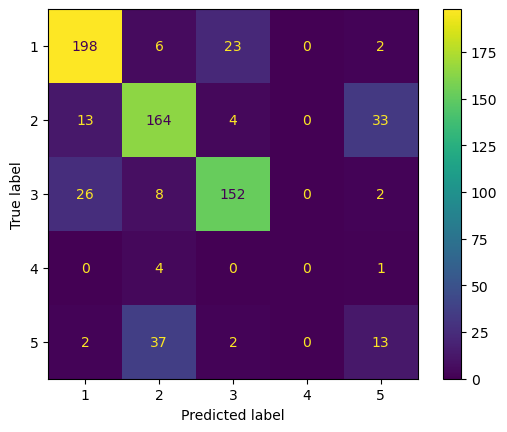

Accuracy Simple Deep Learning model:  0.763768115942029


In [46]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

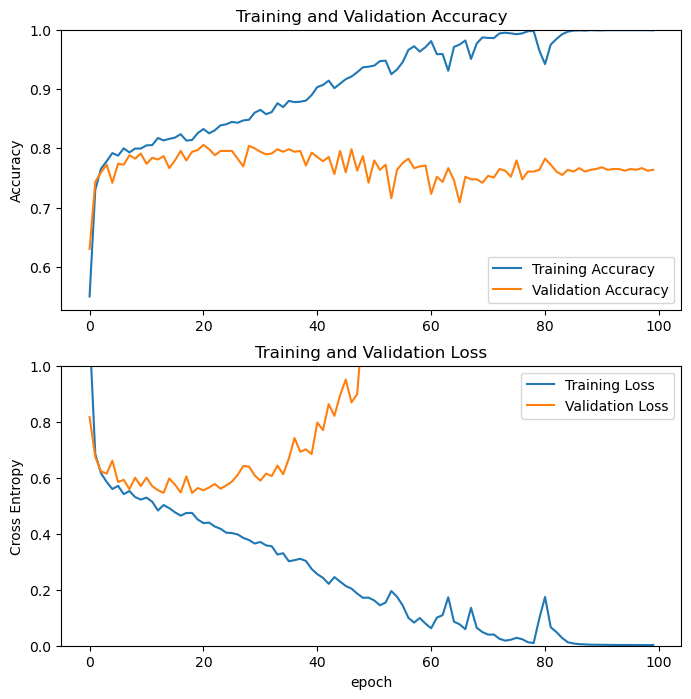

In [47]:

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Step 6. Recurrent Neural Networks (RNNs) classification

Recurrent Neural Networks (RNNs): RNNs can be used to analyze sequential data such as time series data, which can be useful for analyzing the temporal information present in Sentinel-2 imagery.

In [48]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 40

units = 64


# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(kernel*kernel, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(kernel*kernel, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [49]:
RNNs_model = build_model(allow_cudnn_kernel=True)

RNNs_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


history3=RNNs_model.fit(
    X_train_nn, Y_train, epochs=100,callbacks=[SelectiveProgbarLogger(verbose = 1,epoch_interval=20)],  verbose=0, validation_data=(X_val_nn, Y_val), batch_size=batch_size
)

Epoch 1/100


2023-01-18 02:14:53.857457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:14:53.998472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:14:54.254318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:14:56.297469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:14:56.365436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 4s 94ms/sample - loss: 1.6413 - accuracy: 0.5351 - val_loss: 2.0972 - val_accuracy: 0.3101
Epoch 21/100
44/44 [==============================] - 1s 28ms/sample - loss: 0.6239 - accuracy: 0.7837 - val_loss: 2.8529 - val_accuracy: 0.3391
Epoch 41/100
44/44 [==============================] - 1s 28ms/sample - loss: 0.5718 - accuracy: 0.7949 - val_loss: 2.9365 - val_accuracy: 0.4449
Epoch 61/100
44/44 [==============================] - 1s 28ms/sample - loss: 0.5270 - accuracy: 0.8058 - val_loss: 0.6700 - val_accuracy: 0.7855
Epoch 81/100
44/44 [==============================] - 1s 29ms/sample - loss: 0.5189 - accuracy: 0.8076 - val_loss: 0.6783 - val_accuracy: 0.7754


In [50]:
y_pred_rnn_p = RNNs_model.predict(X_val_nn)

print("Prediction example: ", y_pred_rnn_p[0,:], " Class: ", np.argmax(y_pred_rnn_p[0,:]))

 1/22 [>.............................] - ETA: 9s

2023-01-18 02:17:11.496155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 02:17:11.545445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 1s 19ms/step
Prediction example:  [-2.357453    4.637013    3.5896478   0.43254155 -1.7696328   1.8178757
 -2.2364833  -1.3458402  -1.3120202  -2.6468441 ]  Class:  1


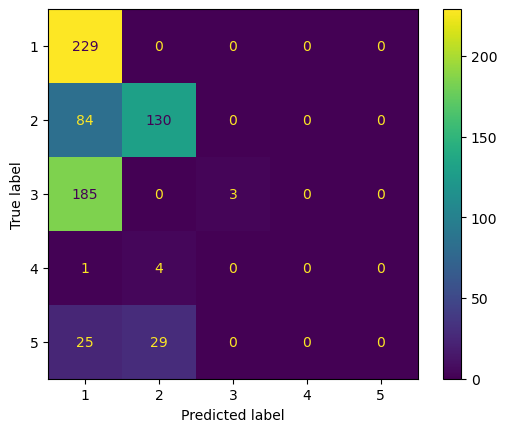

Accuracy Simple Deep Learning model:  0.5246376811594203


In [51]:
y_pred_rnn = np.argmax(y_pred_rnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_rnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)

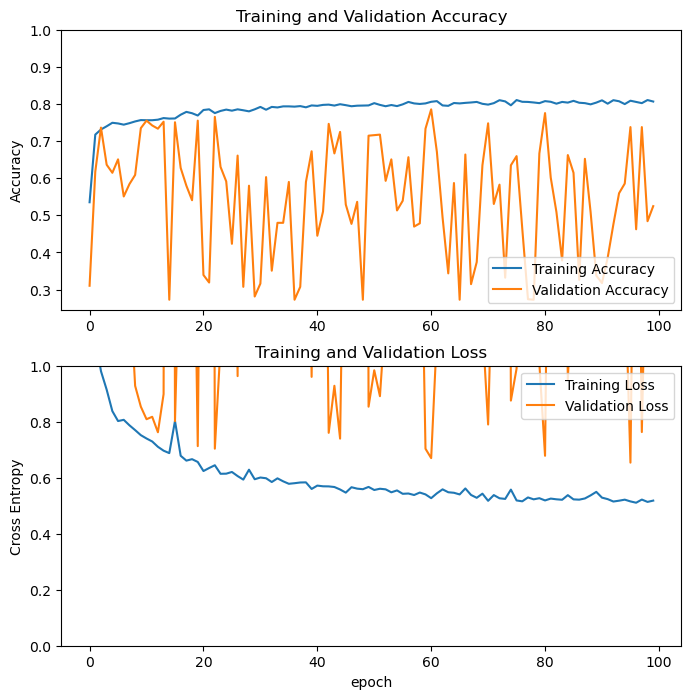

In [52]:

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()